In [1]:
import numpy as np
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
project_path = "/workspaces/bha2"
conn_sizes = [183, 391, 568, 729, 964, 1242, 1584, 1795, 2165]
gammas_vec = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

lvlmin = 5
lvlmax = 60
max_crossmod_value = []
max_crossmod_gamma = []
max_crossmod_level = []
max_crossmod_small_rois_perc = []
for conn_size in conn_sizes:
    if os.path.exists(
        os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
    ):
        fcm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")
        )
        scm = np.load(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy")
        )
        print("fcm and scm loaded from tmp folder")
    else:
        sc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc")
        )
        fc_group = load_data(
            os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc")
        )
        fcm, scm = connectome_average(fc_group, sc_group)
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm
        )
        np.save(
            os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm
        )

    zero_rows_sc = np.where(~scm.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
    density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (
        len(scm_nonzero.flatten())
    )
    fcm_thr = density_threshold(fcm_nonzero, density)
    zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
    fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(
        zero_rows_fc, fcm_thr, scm_nonzero
    )
    fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
    scm_bin = np.where(scm_nonzero > 0, 1, 0)

    crossmod_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))
    small_mods_perc_gammas = np.empty((lvlmax - lvlmin, len(gammas_vec)))
    for g in gammas_vec:
        tree = json.loads(
            open(
                os.path.join(
                    project_path,
                    "data",
                    "processed",
                    "n" + str(conn_size),
                    "tree_weighted_correlation_g_" + str(g) + ".json",
                )
            ).read()
        )

        crossmod = []
        mod_sc = []
        mod_fc = []
        sim_lvl = []
        small_mods_perc = []
        for l in range(lvlmin, lvlmax):
            level, labels = level_from_tree(tree, l)
            roi_size = []
            for idx, rois in enumerate(level):
                roi_size.append(len(rois))
            small_mods = np.where(np.array(roi_size) < 10)[0] + 1
            small_mods_perc.append(len(small_mods) / l)
            T = T_from_level(level)
            sim = np.nanmean(similarity_level(fcm_nonzero, scm_nonzero, level))
            mod_sc_lvl = modularity(scm_nonzero, T)
            mod_fc_lvl = modularity(fcm_nonzero, T)
            c = pow((sim * mod_sc_lvl * mod_fc_lvl), (1 / 3))
            crossmod.append(c)
        crossmod_gammas[:, gammas_vec.index(g)] = crossmod
        small_mods_perc_gammas[:, gammas_vec.index(g)] = small_mods_perc
    max_crossmod_value.append(np.max(crossmod_gammas))
    x, y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
    levels_vec = np.arange(lvlmin, lvlmax)
    max_crossmod_gamma.append(gammas_vec[y[0]])
    max_crossmod_level.append(levels_vec[x][0])
    max_crossmod_small_rois_perc.append(small_mods_perc_gammas[x[0]][y[0]])

fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder
fcm and scm loaded from tmp folder


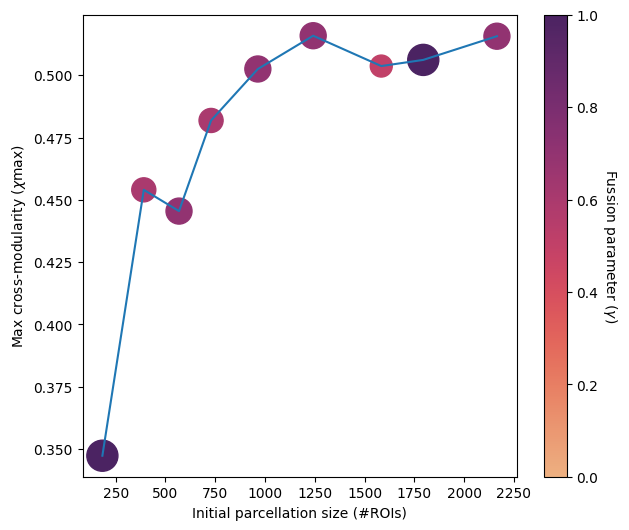

In [12]:
plt.figure(figsize=(7, 6))
plt.plot(conn_sizes, max_crossmod_value)
plt.xlabel("Initial parcellation size (#ROIs)")
plt.ylabel("Max cross-modularity (" + r"$\chi$" + "max)")
# Add label to the colorbar (fussion parameter (gamma))

plt.scatter(
    conn_sizes,
    max_crossmod_value,
    s=np.array(max_crossmod_gamma) * 500,
    c=np.array(max_crossmod_gamma),
    cmap="flare",
    vmin=0,
)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label("Fussion parameter (" + r"$\gamma$" + ")", rotation = 270)

plt.savefig(
    os.path.join(
        project_path, "data", "figures", "initial_parcellation_selection.svg"
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)